# Predicting Profile Features Based on Dialogue
####  Language & Speech & Dialogue Processing Project
*Sam Titarsolej, Ying Liem, Selina Khan*


## Table of Contents


1. Introduction
2. Experimental Setup
    * South Park dataset
    * Friends dataset
    * Movies dataset
    * Approaches  
3. Evaluation
    * Results
4. Findings
    * Discussion
5. Conclusion

In [1]:
# General imports
import re
import nltk
import json
import time
import requests
import data_utils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from bs4 import BeautifulSoup
from collections import Counter, defaultdict

# Imports for the age & gender model
import torch
import transformers as ppb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

# Imports for the personalities model
import personalities.configuration as config
from personalities.training import train_persona

## Introduction

Dialogue is rich in information and essential for human conversation. In a dialogue, one can convey pieces of info they want their conversation partner to know. For example, plans for tomorrow, newest updates about their lives, etc. However, dialogue can also be used to retrieve underlying information about the conversers. Research suggests that characteristics such as gender[[1]](https://journals.sagepub.com/doi/10.1177/0023830914549084), age[[2]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3783449/) and personality[[2]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3783449/) can influence one’s language usage. Moreover, there's a trend in how such profile features influence language use across feature categories. The aim for this project is to use existing models to propose a method to extract various character traits from dialogue, rather than developing a perfectly functioning model.

Our research question is hereby proposed as follows: “to what extent can dialogue be used to form a profile of a person?”. We aim to answer this question using personas from movies and TV shows, since a lot of data is available in the form of dialogues and profile features. Moreover, this research will focus on the profile features gender, age and personality, resulting in the following subquestions:

1.   “To what extent can dialogue be used to predict the gender of a TV show or movie character?”
2.   “To what extent can dialogue be used to predict the age of a TV show or movie character?”
3. “To what extent can dialogue be used to predict the personality of a TV show or movie character?”

To illustrate the research questions, in the TV-show 'Brooklyn 99', the main character Jake Peralta is an adult male with a quirky personality. By merely analysing the transcript of the show, one could guess Jake's profile features. Take his usage of the word 'bro', which is more commonly used by men. Moreover, he uses words that would normally not be included in a child's vocabulary and doesn't use old-fashioned words that could be seen in the vocabulary of elderly. Based on such observations, one could make an estimation that Jake is an adult. Lastly, a lot of jokes can be found in Jake's dialogue, which could show that he has a quirky personality. \\
However, trends between profile features and dialogue aren't concrete and certain. There are females that also use 'bro' to call their male friend. Also, some children have a much broader vocabulary, whereas not all elderly use old-fashioned words and might even know and use some internet slang. And of course, personalities don't have black and white definitions; you could describe someone as quirky, but that doesn't necessarily mean he/she makes a lot of jokes. Nevertheless, there could be some general trends in language use across profile features that would work for most people. 
Therefore, we will investigate to what extent dialogue can be used to predict gender, age and personality of a TV show or movie character. <br><br>



### Related Literature

Quite some research has already been done in the attempt to extract specific features from dialogue. There are many published papers and articles proposing methods to determine a person’s gender based on spoken dialogues. This includes both audio-based approaches[[3]](http://www.cs.columbia.edu/~sarahita/papers/speech_prosody16.pdf)[[4]](https://ieeexplore.ieee.org/document/7342709)[[5]](https://iranjournals.nlai.ir/bitstream/handle/123456789/621435/50D7B725BB44A32A9317C554F68ADC2D.pdf?sequence=-1) and textual approaches[[6]](https://www.researchgate.net/publication/306093567_Gender-Distinguishing_Features_in_Film_Dialogue)[[7]](https://www.researchgate.net/publication/332017320_Gender_Classification_Using_Sentiment_Analysis_and_Deep_Learning_in_a_Health_Web_Forum). Age group classification of a person based on spoken dialogues have also been researched to some extent[[8]](https://www.aclweb.org/anthology/E17-2030.pdf). Research in age categorization involves more audi-based approaches, as opposed to a textual approach we aim to research. Jiang et al.[[9]](https://arxiv.org/abs/1911.09304) have researched text-based classification of personality, and will be of great inspiration to us in our research. 

## Experimental Setup
We present an approach for automatic age, gender and personality classification. The gender and age approaches use a pre-trained contextual embedding model (‘DistilBERT’) and a logistic regression model. For predicting personality traits, a bidirectional LSTM with attention mechanisms is proposed.

### Profile features
As mentioned earlier, the profile features we focused on are gender, age and personality. While acknowledging that there are more than two genders, we will stick with two classes within the scope of this project: male and female. Age has a much wider range of possible values, therefore we decided to create age categories to make classification easier and more logical. The categories we settled on are ‘kid (0-9)', 'teen (10-19)', 'YA (20-35)' (young-adult), 'adult (36-50)' and 'elderly (50+)'. For personality, we will be using the big five personality traits, a widely used and accepeted taxonomy of five personality traits. The traits are: agreeableness, conscientiousness, extroversion, openess and neuroticism.

### Datasets

To perform this investigation we used three dialogue datasets, namely from the cartoon ‘South Park’, the convokit corpus of the TV-show ‘Friends’ and the convokit ‘Cornell Movie-Dialogs Corpus’. Furthermore, we used the Wiki Fandom pages of the shows ‘South Park’ and ‘Friends’ to obtain gender and age labels for the characters using a web-scraping method. The movie dataset already included gender labels, however ages of the characters had to be manually annotated. For the personality labels, we were greatly inspired by Jiang et al.[[9]](https://arxiv.org/abs/1911.09304) and used their annotated Friends personalities, which they obtained through crowdsourcing, for our own research. The training and testing of the personality classification model was thereby limited to usage of only the Friends dataset. 

In [2]:
# Load stop words and swear words files.
# From: https://gist.github.com/sebleier/554280
with open('data/stop_words.txt', 'r') as f:
    stop_words = f.read().split('\n')
# From: https://www.cs.cmu.edu/~biglou/resources/bad-words.txt
with open('data/swear_words.txt', 'r') as f:
    swear_words = f.read().split('\n')

Four functions used for statistical analysis are defined.

In [3]:
def simplify(x):
    x = re.sub(r'[^\w\s]', '', x)
    x = x.lower()
    x = x.split()
    return x

# Calculate word frequency for each specified character
def word_freq(characters, df):
    axs = tuple(['ax' + str(i) for i in range(len(characters))])    
    wordfreqs = []
    
    for character in characters:
        df_char = df[df['speaker'] == character]['text'].apply(simplify)
        char = [item for sublist in df_char.tolist() for item in sublist]
        char = [word for word in char if word not in stop_words]
        counts = Counter(char).most_common(10)
        wordfreqs.append(dict((x, y) for x, y in counts))
        
    fig, axs = plt.subplots(len(axs), figsize=(10, 20))
    fig.suptitle('Word frequency per character')
    for i, ax in enumerate(axs):
        ax.set_title(characters[i])
        ax.bar(wordfreqs[i].keys(), wordfreqs[i].values())

# Calculate average utterance length for each specified character
def seq_length(characters, df):
    avgs = []
    
    for i, char in enumerate(characters):
        seqs = df[df['speaker'] == char]['length'].tolist()
        avg_len = sum(seqs)/len(seqs)
        avgs.append(str(char + ' has an average utterance length of ' + str(avg_len)))
    return avgs

# Calculate the swearword-rate of each specified character
def swearing(characters, df):
    result = []
    
    for char in characters:
        df_char = df[df['speaker'] == char]['text'].apply(simplify)
        words = [item for sublist in df_char.tolist() for item in sublist]
        wordlist = [word for word in words if word not in stop_words]

        sw_words = 0
        swears = []
        for word in wordlist:
            if word in swear_words:
                sw_words += 1
        perc = round(sw_words / len(wordlist) * 100)
        result.append(str(char + ' speaks ' + str(len(wordlist)) + ' words, of which ' 
                          + str(sw_words) + ' are swear words. This is ' + str(perc) + '%'))
    return result

As mentioned before, we used the South Park and Friends Wiki fandom pages to obtain gender and age labels for all the characters. This was done using web-scraping, which was enabled by a clear structure in the fandom pages. This task is defined in the function '*label*'. As these labels are essential for training the prediction models, the characters with no labels will be excluded from the dataset.

<u>Gender</u>: The extraction of gender labels was relatively simple. To stick to the selected gender categories, characters with different or multiple genders are labelled with 'None' (no label) to also be excluded from the dataset.

<u>Age</u>: The South Park characters remain the same age throughout the whole show, which if known was stated on the Wiki Fandom pages. Sometimes an estimation was given, e.g. '10-11'. For simplicity and ease of computation, only the first age was taken as the actual age. For Friends, the characters age around a decade throughout the whole series. Therefore, the Wiki fandom pages only stated the birth year. We decided to take about the median age. It can be noted that only the birth years of the main characters were available. Nevertheless, this corresponds with our choice to only include the characters with significant or sufficient amount of dialogue.

In [4]:
# Define the age categories
def age_category(age):
    if 0 <= age <= 9:
        category = 'kid (0-9)'
    elif 10 <= age <= 19:
        category = 'teen (10-19)'
    elif 20 <= age <= 35:
        category = 'young adult (20-35)'
    elif 36 <= age <= 50:
        category = 'adult (36-50)'
    else:
        category = 'elderly (50+)'
    return category

# Use web-scraping to find the gender and age of the TV-show characters
def label(show, characters):
    genders = defaultdict(str)
    ages = defaultdict(str)
    
    cont_class = 'pi-item pi-data pi-item-spacing pi-border-color'
    hold_class = 'pi-data-value pi-font'
    
    for character in tqdm(characters):        
        try:
            c_name = character.replace(' ', '_')
            url = 'https://' + show + '.fandom.com/wiki/' + c_name
            soup = BeautifulSoup(requests.get(url).content, 'lxml')
        except requests.exceptions.HTTPError as e:
            print(e.code)
            if e.code == 404:              # Character's profile features are unkown or not available
                genders[character], ages[character] = None, None
                print(f'no info for {character}')
                continue
            else:
                raise e
            
        # Extract gender
        gender_div = soup.find('div', { 'class': cont_class, 'data-source': 'gender' })
        if gender_div is not None:
            gender = gender_div.find('div', { 'class': hold_class }).get_text()
            if (gender == 'Male') or (gender == 'Female'):
                genders[character] = gender

        # Extract age
        if show == 'southpark':
            age_div = soup.find('div', { 'class': cont_class, 'data-source' : 'age'})
            if age_div is not None:
                age = age_div.find('div', { 'class': hold_class }).get_text()
                number = re.findall("[\dA-Za-z]*", age)[0]
                if number.isdigit():
                    age = age.split('[')[0]
                    age = age.split('-')[0]
                    ages[character] = age_category(int(age))
        else:
            dob_div = soup.find('div', { 'class': cont_class, 'data-source': 'dob' })
            if dob_div is not None:
                dob = dob_div.find('div', { 'class': hold_class }).get_text()
                year = int(re.match(r'.*([1-3][0-9]{3})', dob).group(1))
                age = 1998 - year
                ages[character] = age_category(int(age))
                
    return genders, ages

#### South Park dataset
The South-Park dataset spans over 10 seasons specifying the season number, utterance and character description for each row in the dataset. We only keep the character name and dialogue line (utterance) as the other aspects are irrelevant to the task at hand. Some columns are renamed, in order to let the dataframes of the three datasets match. Moreover, only the characters with a significant amount of dialogue lines are included in the dataset and labelled.

In [5]:
def load_southpark(in_file):
    # Load input file
    df = pd.read_csv(in_file)
    df = df[['Character', 'Line']]
    df = df.rename(columns={ 'Character': 'speaker', 'Line': 'text' })
    df['text'] = df['text'].apply(lambda x: x.replace('\n', ''))
    
    significant_characters = df['speaker'].value_counts()[:30]
    genders, ages = label('southpark', significant_characters.index)
    
    df['source'] = 'South Park'
    df['gender'] = df['speaker'].apply(lambda x: genders[x])
    df['age'] = df['speaker'].apply(lambda x: ages[x])

    df['length'] = df['text'].apply(lambda x: x.count(' ') + 1)

    return df

In [6]:
south_park = load_southpark('data/southpark.csv')

100%|██████████| 30/30 [00:08<00:00,  3.72it/s]


A statistical analysis of the dataset was done to give insights in what the dataset is composed of. This could help us later in the process of evaluating when explaining the results and discussing performance. 

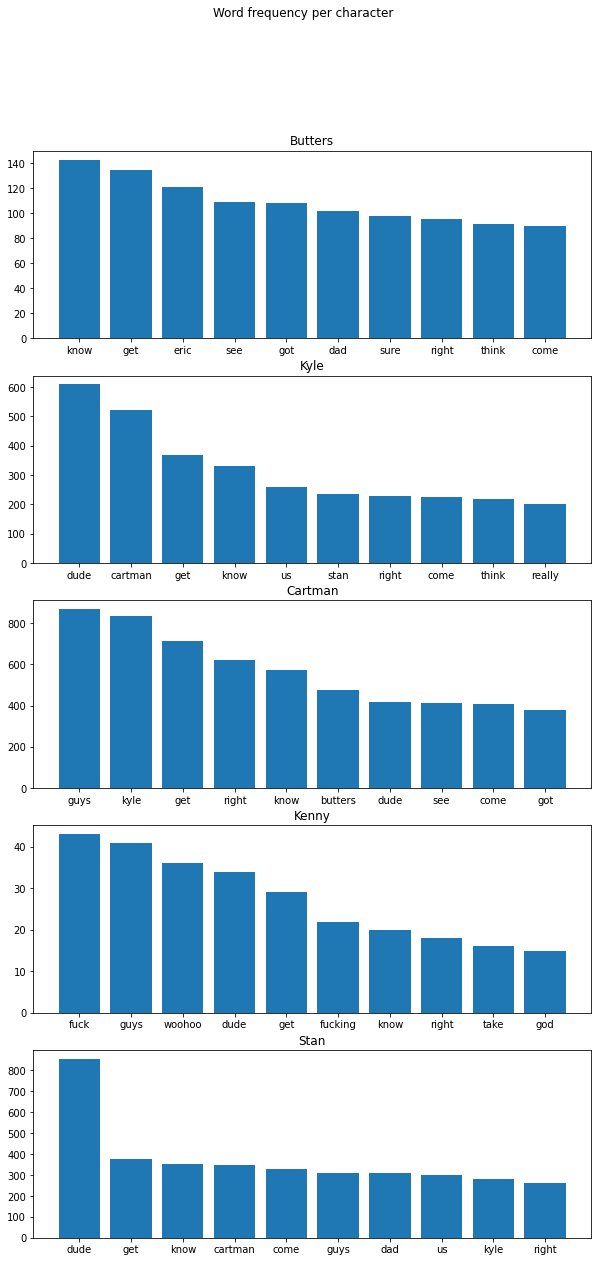

In [7]:
word_freq(['Butters', 'Kyle', 'Cartman', 'Kenny', 'Stan'], south_park)

We notice that the main characters of the show use quite casual street langage.

In [8]:
seq_length(['Butters', 'Kyle', 'Cartman', 'Kenny', 'Stan'], south_park)

['Butters has an average utterance length of 11.620292083013068',
 'Kyle has an average utterance length of 9.190449359064656',
 'Cartman has an average utterance length of 13.69500716185799',
 'Kenny has an average utterance length of 5.009080590238366',
 'Stan has an average utterance length of 9.195703125']

In [9]:
swearing(['Butters', 'Kyle', 'Cartman', 'Kenny', 'Stan'], south_park)

['Butters speaks 13990 words, of which 637 are swear words. This is 5%',
 'Kyle speaks 30234 words, of which 2019 are swear words. This is 7%',
 'Cartman speaks 63752 words, of which 4432 are swear words. This is 7%',
 'Kenny speaks 1990 words, of which 227 are swear words. This is 11%',
 'Stan speaks 32874 words, of which 1970 are swear words. This is 6%']

We also notice that the young teenagers use a lot of profound language, this is important to keep in mind when evaluating results, since it could have a significant influence.

#### Friends Dataset

The Friends corpus also spans 10 seasons and includes utterance id, utterance, to who the utterance is spoken to, the tokens (tokenized utterance/line), the season and episode information. Similar to the South Park dataset, only the relevant columns were kept and similar processing steps such as labelling are performed.

In [10]:
def load_friends(in_file):
    with open(in_file) as f:
        content = f.readlines()
        
    # Load json lines and keep columns of interest
    df = pd.DataFrame([json.loads(line) for line in content])
    df = df[['speaker', 'text']]
    df = df[df['speaker'] != 'TRANSCRIPT_NOTE']
    
    significant_characters = df['speaker'].value_counts()[:30]
    genders, ages = label('friends', significant_characters.index)
    
    df['source'] = 'Friends'
    df['gender'] = df['speaker'].apply(lambda x: genders[x])
    df['age'] = df['speaker'].apply(lambda x: ages[x])

    df['length'] = df['text'].apply(lambda x: x.count(' ') + 1)
    
    return df

In [11]:
friends = load_friends('data/friends.jsonl')

100%|██████████| 30/30 [00:06<00:00,  4.78it/s]


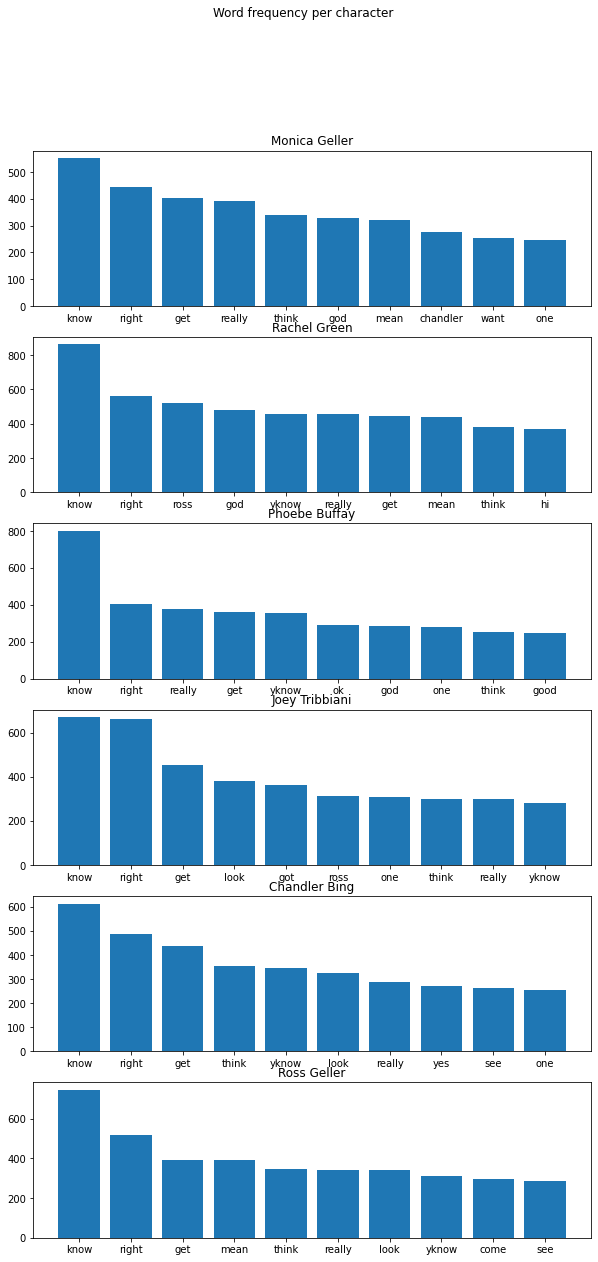

In [12]:
word_freq(['Monica Geller', 'Rachel Green', 'Phoebe Buffay', 'Joey Tribbiani', 'Chandler Bing', 'Ross Geller'], friends)

We see that the statistical analysis of the Friends dataset doesn't seem particularly interesting, so we don't expect that the results will be influences a lot by the type of dialogue in this dataset.

In [13]:
seq_length(['Monica Geller', 'Rachel Green', 'Phoebe Buffay', 'Joey Tribbiani', 'Chandler Bing', 'Ross Geller'], friends)

['Monica Geller has an average utterance length of 9.778771475641328',
 'Rachel Green has an average utterance length of 10.466938163112207',
 'Phoebe Buffay has an average utterance length of 10.82239023743202',
 'Joey Tribbiani has an average utterance length of 10.534023128423616',
 'Chandler Bing has an average utterance length of 10.135971055088703',
 'Ross Geller has an average utterance length of 10.43193974456937']

In [14]:
swearing(['Monica Geller', 'Rachel Green', 'Phoebe Buffay', 'Joey Tribbiani', 'Chandler Bing', 'Ross Geller'], friends)

['Monica Geller speaks 36412 words, of which 967 are swear words. This is 3%',
 'Rachel Green speaks 41765 words, of which 1161 are swear words. This is 3%',
 'Phoebe Buffay speaks 35690 words, of which 1008 are swear words. This is 3%',
 'Joey Tribbiani speaks 38091 words, of which 894 are swear words. This is 2%',
 'Chandler Bing speaks 37933 words, of which 949 are swear words. This is 3%',
 'Ross Geller speaks 42095 words, of which 857 are swear words. This is 2%']

The amount of swearing doesn't stand out either.

#### Movies Dataset
This dataset is composed of multiple movies and hand annotated for the age and gender fields.

In [15]:
def load_movies(lines_file, meta_file):
    # Load dataframes
    kwargs = { 'delimiter': '\ \+\+\+\$\+\+\+\ ', 'encoding' : 'latin-1', 'header' : None }
    line_df = pd.read_csv(lines_file, engine='python', **kwargs)
    meta_df = pd.read_csv(meta_file, engine='python', **kwargs)

    # Set column names
    line_df.columns = ['line_id','char_id','movie_id','char_name','text']
    meta_df.columns = ['char_id','char_name','movie_id', 'movie_name','gender','credits_pos']

    # Fromalize meta dataframe
    meta_df['gender'] = meta_df['gender'].str.strip()
    meta_df = meta_df[meta_df['gender'] != '?']
    meta_df['gender'] = meta_df['gender'].apply(lambda x: 'Male' if x in ['m', 'M'] else 'Female') 

    # Merge meta and lines df's on movie_id and char_name
    df = pd.merge(line_df, meta_df, how='inner', on=['movie_id', 'char_name'],
                  left_index=False, right_index=False, sort=True, copy=False,
                  indicator=False).drop('char_id_y', axis=1)
    df = df.rename(columns={ 'char_id_x': 'char_id' })

    # Cleanup final df
    df['age'] = df['char_id'].apply(lambda x: data_utils.MOVIE_CHAR_TO_AGE.get(x))
    df = df[['movie_name', 'char_name', 'text', 'age', 'gender']]
    df = df.rename(columns={ 'movie_name': 'source', 'char_name': 'speaker' })

    df['length'] = df['text'].apply(lambda x: x.count(' ') + 1)

    return df

In [16]:
movies = load_movies('data/movie_lines.txt', 'data/movie_meta.txt')

In [17]:
full_df = pd.concat([movies, friends, south_park])
full_df = full_df[full_df['length'] < 100]

### Approaches
In this section, we will elaborate on the models we have used, after which we initialize and train our classification models on the datasets. 

#### Models used
BERT (Bidirectional Encoder Representations from Transformers) is a method of pre-training language representations. This means that we train a general-purpose model which is able to understand the language on a text corpus (In our case, the datasets mentioned earlier). The pre-trained model is thereafter used for NLP tasks, such as text classification. We have decided to use BERT since it is a state-of-the-art encoder which has shown to outperform previous methods. BERT’s key technical innovation is the application of a bi-directional Transformer (an attention model) on language modelling tasks. This model has a better sense of context within a  language and has shown outstanding results for NLP-tasks[9]. Moreover, its code is open-source and user-friendly, making it possible to actually use and implement it.

We used the smaller version of Google’s BERT model, called ‘DistilBERT’ to process the input dialogue lines and extract information from it. A smaller version was used since we had limited computational power. The information is encoded in the form of a vector/matrix that can be seen as the embedding of the input. This vector is used by the scikit Logistic Regression model to actually do the classification by predicting the labels. We used a pre-trained DistilBERT model that was trained on the English language.

In [18]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load BERT
bert_model = ppb.DistilBertModel.from_pretrained('distilbert-base-uncased')
bert_tokenizer = ppb.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = bert_model.to(device)

The `get_bert_features` function does the following: encoding the dialogue lines in a desired-format for BERT, padding and masking the input and finally returning the features. The BERT tokenizer, besides encoding the sentences, also adds special tokens, which are needed for classification, at the beginning and end of a sequence. Next, the tokenizer replaces the tokens with corresponding ids from the embedding table. This results in a list of lists or vectors of uneven lengths. In order to be able to give the input to DistilBERT in one go, we need to make it a suitable input matrix. To do so, the vectors need to be padded to equal sizes. The shorter sentences are padded with an id of 0. Nevertheless, we don’t want DistilBERT to read those zeroes, hence we mask them to let BERT know that they should be ignored. Finally, the input matrix can be given to DistilBERT. The processed results are given to ‘last_hidden_states’. The features we want is only a slice of the full output, corresponding to the complete sentence embeddings. 

The `get_bert_features` function was used on both the age and gender training and test sets to obtain age and gender features as input for the LR models. It should be noted that the padding step of the `get_bert_features` function results in a sparse matrix, which can take a lot of unnecessary computing power. For example, if in the dataset, there’s one sentence that’s 200 tokens long, whilst most lines only consist of 50 tokens, then the resulting matrix will have a lot of insignificant zeros. To limit the amount of zeros in the input matrix, we constrain the length of sentences given to the `get_bert_features` function.
The features and corresponding labels were first again split into training and test features with a 3:1 ratio. Here, the test features are used to test the accuracy of the LR model. We used separate LR models for age and gender, because they are two separate predictions. The models were trained using the train features and tested with the test features.

In [19]:
def get_bert_features(batch):
    encoded = batch['text'].apply(lambda x: bert_tokenizer.encode(x, add_special_tokens=True))
    
    # Apply zero-padding
    max_len = max(len(x) for x in encoded.values)
    padded = np.array([x + [0] * (max_len - len(x)) for x in encoded.values])

    # Calculate attention mask
    mask = np.where(padded != 0, 1, 0)
    
    # Create input tensors for BERT
    X = torch.tensor(padded).to(device)
    mask = torch.tensor(mask).to(device)
    
    # Forward input through model
    with torch.no_grad():
        y = bert_model(X, attention_mask=mask)
    result = y[0][:, 0, :].cpu().numpy()
    
    # Clear CUDA memory
    if device == 'cuda':
        del X, mask, y
        torch.cuda.empty_cache()
    return result

In [20]:
batch_size = 256

In [21]:
full_df['features'] = None
for i in tqdm(range(0, len(full_df), batch_size)):
    features = get_bert_features(full_df[i:i + batch_size])
    features_df = pd.DataFrame(data={ 'features': list(features) })
    full_df.iloc[i:i + batch_size, -1] = pd.DataFrame(data={ 'features': list(features) })

100%|██████████| 1459/1459 [12:41<00:00,  1.92it/s]


In [22]:
gen_df = full_df[(full_df['gender'].notnull()) & (full_df['gender'] != '')]
age_df = full_df[(full_df['age'].notnull()) & (full_df['age'] != '')]

Male      234140
Female    101226
Name: gender, dtype: int64

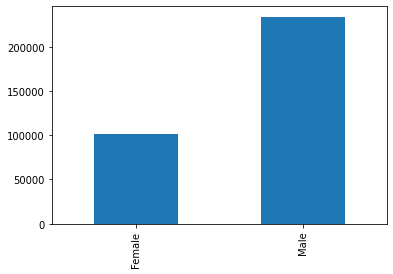

In [23]:
gen_df['gender'].value_counts().sort_values().plot(kind='bar')
gen_df['gender'].value_counts()

young adult (20-35)    53226
teen (10-19)           29774
adult (36-50)           6036
kid (0-9)               1197
elderly (50+)            408
Name: age, dtype: int64

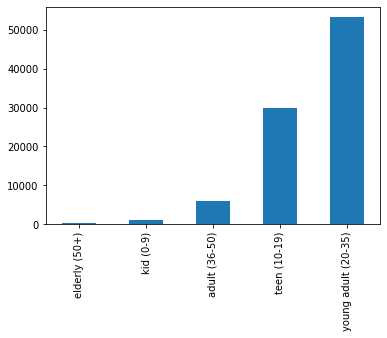

In [24]:
age_df['age'].value_counts().sort_values().plot(kind='bar')
age_df['age'].value_counts()

Since the distributions were rather skewed in all the shows, we had to mix and match data from the three corpora in order to obtain somewhat fair training and test datasets. Doing so helps prevent the classifier from learning biased predictions, because of certain labels occurring much more frequently in the training data. This opposed our original idea of using one or two datasets as training data and the others as test data to see if the trained model also worked on other corpora.

<AxesSubplot:>

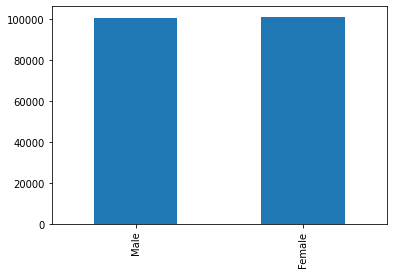

In [25]:
subs = (
    gen_df[gen_df['gender'] == 'Male'].sample(frac=0.43),
    gen_df[gen_df['gender'] == 'Female']
)

gen_df = pd.concat((subs))
gen_df['gender'].value_counts().sort_values().plot(kind='bar')

<AxesSubplot:>

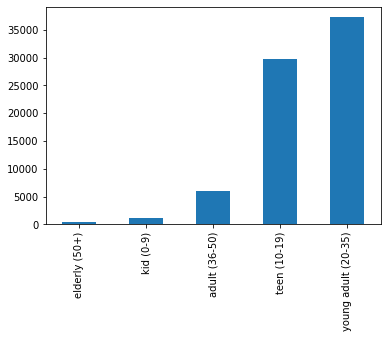

In [26]:
subs = (
    age_df[age_df['age'] == 'young adult (20-35)'].sample(frac=0.7),
    age_df[age_df['age'] == 'teen (10-19)'],
    age_df[age_df['age'] == 'adult (36-50)'],
    age_df[age_df['age'] == 'kid (0-9)'],
    age_df[age_df['age'] == 'elderly (50+)']
)

age_df = pd.concat((subs))
age_df['age'].value_counts().sort_values().plot(kind='bar')

In [27]:
# Initialize models
gen_model = LogisticRegression(n_jobs=4)
age_model = LogisticRegression(n_jobs=4)

We selected a range of characters from the 3 datasets with specific gender and age labels. For the training dataset we sampled the dialogue equally across those with different gender and age labels. The test set consists of multiple dataframes with the residual dialogue of one specific character. This test set will be used to test the accuracy of the model, predicting labels for a specific character. We created two separate training and test sets for age and gender.

Using the training datasets, the logistic regression models are trained.

In [28]:
split = train_test_split(gen_df['features'], gen_df['gender'], test_size=0.2)
X_gen_train, X_gen_test, y_gen_train, y_gen_test = split

X_gen_train = np.array(X_gen_train.values.tolist())
y_gen_train = np.array(y_gen_train.values.tolist())

gen_model.fit(X_gen_train, y_gen_train)

LogisticRegression(n_jobs=4)

In [29]:
split = train_test_split(age_df['features'], age_df['age'], test_size=0.2)
X_age_train, X_age_test, y_age_train, y_age_test = split

X_age_train = np.array(X_age_train.values.tolist())
y_age_train = np.array(y_age_train.values.tolist())

age_model.fit(X_age_train, y_age_train)

LogisticRegression(n_jobs=4)

For personality predictions a bidirectional *long short term memory* (LSTM) network with attention mechanisms is used. A LSTM is a type of *recurrent neural network* (RNN) that learns to model sequences of data. By modelling the sequences in both directions (from beginning to end and vice versa; bidirectional), the model learns to make predictions on the sequence. Attetion mechanisms are used to allow the model to learn what information is relevant at each step of a sequence.

Code from the <a href='https://github.com/hjian42/automatic-personality-prediction'>Modeling Personality with Attentive Networks and Contextual Embeddings</a> repository is used and sligthly modified to train the model. The `train_persona` function trains the LSTM model using 10-fold cross-validation, from which the best performing model is stored, such that the model can be used later on. 10-fold cross-validation uses the available data more efficiently, as all data is used during training, instead of a smaller (training) subset. The amount of data available is very limited which makes 10-fold cross-validation necessary. To reduce the complexity of the task, for each personality trait a seperate model is trained. Each model then learns to score a piece of conversation for a single personality trait.

In [30]:
config.ModelName = 'Attention'
config.Params.n_epoch = 50

persona_acc = train_persona(config)

The size of data is 711
BEFORE Pruning:
Min=2, Mean=56, Max=443
Total majority is 56.962025316455694 for cAGR.
Real Vocab Size: 3542
Truncated Vocab Size: 10000
AFTER Pruning:
Min=1, Mean=29, Max=218
Total majority is 56.962025316455694 for cAGR.
working on ==cAGR==
----cAGR: 1----
----highest evaluation accuracy is 63.888890
----dominant distribution in data is 56.962025
New best evaluation, saving model to models/cAGR_best.h5
working on ==cAGR==
----cAGR: 2----
----highest evaluation accuracy is 69.014084
----dominant distribution in data is 56.962025
New best evaluation, saving model to models/cAGR_best.h5
working on ==cAGR==
----cAGR: 3----
----highest evaluation accuracy is 63.380283
----dominant distribution in data is 56.962025
working on ==cAGR==
----cAGR: 4----
----highest evaluation accuracy is 57.746476
----dominant distribution in data is 56.962025
working on ==cAGR==
----cAGR: 5----
----highest evaluation accuracy is 67.605633
----dominant distribution in data is 56.962025

working on ==cNEU==
----cNEU: 10----
----highest evaluation accuracy is 57.746476
----dominant distribution in data is 53.305204
The 10-fold CV score is 0.5695618033409119


## Evaluation
To evaluate the trained gender and age prediction model, we run the test dataset with its corresponding labels through the scikit Logistic Regression `score` function. The `score` function computes the mean accuracy of the given input, by running every data row of the test set through the scikit Logistic Regression `predict` function and comparing the predicted label with the actual label. Hence, the mean accuracy represents the percentage of correctly predicted labels.

Validation accuracy of the gender model: 0.6017037293843792


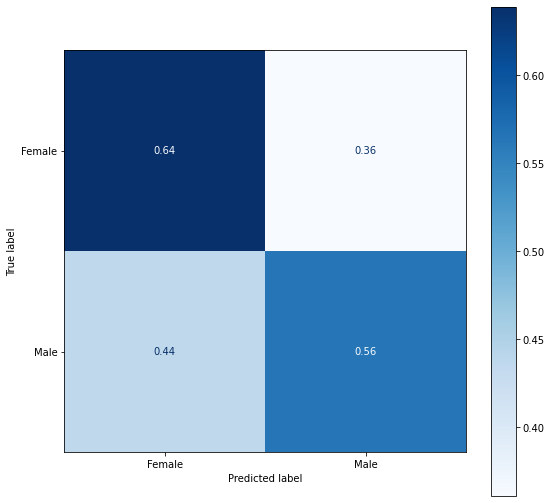

In [31]:
X_gen_test = np.array(X_gen_test.values.tolist())
y_gen_test = np.array(y_gen_test.values.tolist())

gen_acc = gen_model.score(X_gen_test, y_gen_test)
print(f'Validation accuracy of the gender model: {gen_acc}')

fig, ax = plt.subplots(figsize=(9, 9))
plot_confusion_matrix(gen_model, X_gen_test, y_gen_test, cmap=plt.cm.Blues, normalize='true', ax=ax)
plt.show()

Validation accuracy of the age model: 0.6897221292266488


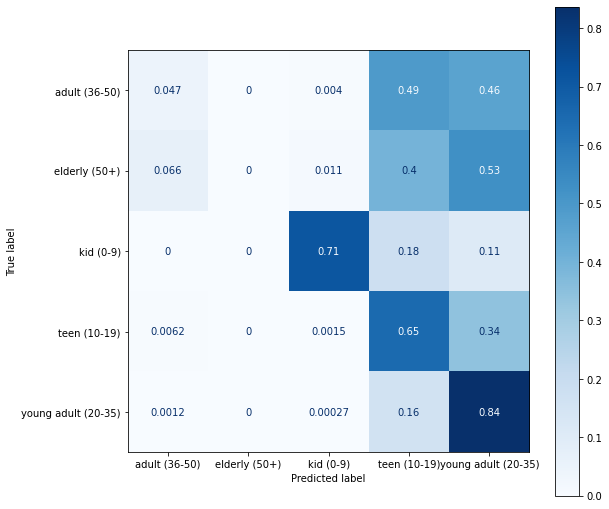

In [32]:
X_age_test = np.array(X_age_test.values.tolist())
y_age_test = np.array(y_age_test.values.tolist())

age_acc = age_model.score(X_age_test, y_age_test)
print(f'Validation accuracy of the age model: {age_acc}')

fig, ax = plt.subplots(figsize=(9, 9))
plot_confusion_matrix(age_model, X_age_test, y_age_test, cmap=plt.cm.Blues, normalize='true', ax=ax)
plt.show()

In [33]:
print(f'10-fold validation accuracy of the personality model: {persona_acc}')

10-fold validation accuracy of the personality model: 0.607859934568405


The gender model gets roughly a 60% accuracy, whereas the age model gets an accuracy of almost 70%. These accuracies are already better than a random/dummy predictor as e.g. for the gender prediction, the categories are roughly 50/50 split into male/female, hence a dummy predictor would have an accuracy of 50%.

The confusion matrices show that the gender model classifies dialogue of a female character slightly more often correct than the dialogue of a male character, with an accuracy of 65% for females against 56% for males. Furthermore, the age model has the highest accuracy of 84% for the young adult category, followed by decent accuracies of 66 and 69% for the categories kid and teen. It can also be noted that the teen category is most often incorrectly classified as a young adult and kids are more frequently incorrectly classified as teens. Lastly, elderly and adults are generally misclassified as either teens or young adults.

Finally, the personalities model makes predictions with average accuracy of 60% over the 10 train/test splits. This is also better than a random classifier could get, as the majority class is again 50% of the dataset. 

### Results

The function below shows more prediction examples and whether it was correct, along with additional information such as the dialogue line that was used to predict the label.

In [34]:
def show_samples(model, df, target, n_samples=25):
    n_samples = 50
    pd.options.display.max_rows = n_samples
    pd.options.display.max_colwidth = 100

    sample_rows = df.sample(n=n_samples)
    y_hat = model.predict(sample_rows['features'].values.tolist())
    return pd.DataFrame({ 'speaker': sample_rows['speaker'],
                          'text': sample_rows['text'],
                          'label': sample_rows[target],
                          'predicted': y_hat,
                          'correct': sample_rows[target] == y_hat})

Thus now the models are able to predict or classify a gender and age label, given a dialogue line. However, we want to predict the gender and age of a character given all his/her dialogue lines. To do so, we simply let the model predict labels for each line of a specific character and take the most frequent label as final prediction. 

In [35]:
def analyze_character_predictions(model, df, characters):
    results = { c: [] for c in ['Speaker'] + list(model.classes_) }
    
    for char in characters:
        char_in = df[df['speaker'] == char]['features'].values.tolist()
        y_hat = model.predict(char_in)
        
        value_counts = pd.Series(y_hat).value_counts()
        value_counts_sum = sum(value_counts)
        
        for c in list(model.classes_):
            c_value = value_counts.get(c)
            if c_value is not None:
                score = c_value / value_counts_sum
                results[c].append(f'{score * 100:.2f}%')
            else:
                results[c].append('0%')
        results['Speaker'].append(char)
        
    return pd.DataFrame(results)

In [36]:
characters = ['Chandler Bing', 'Monica Geller', 'Butters', 'Cartman', 'Stan']

In [37]:
show_samples(gen_model, gen_df, 'gender')

,speaker,text,label,predicted,correct
7146,JUNO,Either I just pissed my pants or...,Female,Male,False
87264,NICKY,"I know. Why didn't you come to me? I mean, this is family, it ain't business. Meanwhile, you mak...",Male,Female,False
196351,LUTHOR,They stop for nothing.,Male,Female,False
29352,SUSAN,Opportunity?,Female,Male,False
50622,MELANIE,"I'll just clear up here, and then dress.",Female,Female,True
182464,WENDY,"Hi, hon. How's it going?",Female,Female,True
213370,JOHN,How much.,Male,Female,False
55839,Joey Tribbiani,Uhuh.,Male,Male,True
59225,Linda,"Oh my God, our house!",Female,Female,True
48505,KAY,Don't you want dinner first?,Female,Female,True


In [38]:
analyze_character_predictions(gen_model, gen_df, characters)

,Speaker,Female,Male
0,Chandler Bing,64.37%,35.63%
1,Monica Geller,74.11%,25.89%
2,Butters,36.17%,63.83%
3,Cartman,28.93%,71.07%
4,Stan,32.06%,67.94%


As the results show above, if we take the prediction with the highest percentage as the final prediction then except for Chandler, all the characters will be correctly classified. Nevertheless, the ones that have correct final predictions still have about 30% of incorrectly classified dialogue.

In [39]:
show_samples(age_model, age_df, 'age')

,speaker,text,label,predicted,correct
63314,Stan,Maybe I should. At least they will understand me. Maybe I should hang with the Goth kids.,teen (10-19),teen (10-19),True
30036,Cartman,"Juden est verboten, a den ascriber utz, kapieda hockuh. Juden est verboten, God dammit!",teen (10-19),teen (10-19),True
54804,Butters,"Hey, do you guys smell that?",teen (10-19),young adult (20-35),False
55654,Joey Tribbiani,Little bit.,young adult (20-35),young adult (20-35),True
21677,Cartman,"Hm, it's kind of a grapey, bleachy flavor.",teen (10-19),teen (10-19),True
29936,Ross Geller,"Awww, man! Really?",young adult (20-35),teen (10-19),False
23087,Kyle,I am sooo sick of that stupid bitch! Blabbin' pussy little skank! Why do people talk on their ph...,teen (10-19),teen (10-19),True
33432,Chandler Bing,"Well, I don't know what mad him so mad, y'know? All I said was that uh, I didn't think this wasn...",young adult (20-35),young adult (20-35),True
27258,Joey Tribbiani,"Felicity and I, we're watching My Giant, and I was thinking, ""I'm never gonna be as good an acto...",young adult (20-35),young adult (20-35),True
24913,BELL,"Yes ma'am, I do.",elderly (50+),young adult (20-35),False


In [40]:
analyze_character_predictions(age_model, age_df, characters)

,Speaker,adult (36-50),elderly (50+),kid (0-9),teen (10-19),young adult (20-35)
0,Chandler Bing,0.27%,0%,0.10%,18.29%,81.34%
1,Monica Geller,0.08%,0%,0.02%,15.45%,84.45%
2,Butters,0.54%,0%,0.12%,61.03%,38.31%
3,Cartman,0.90%,0%,0.11%,68.43%,30.55%
4,Stan,0.26%,0%,0.10%,65.72%,33.92%


Again having the highest percentage as the final prediction leads to all characters shown above to be correctly classified. The characters from Friends (Chandler and Monica) have higher accuracies of roughly 80%, whereas the characters from South Park have accuracies of about 60% or slightly higher. 

## Findings
The reasonable results suggest that it is possible to predict the selected profile features given the dialogue of a person/character. It can even be said that it is possible to have fairly good predictions. However, the predictions aren't always perfect as we haven't acquired +/- 100% accuracy.

The results also indicate that the models are better at predicting age than gender. In addition, it seems as if the age model has more difficulties classifying adults and elderly or that is has a slight bias towards teens and young adults.

### Discussion
We have seen that the accuracy of our system is roughly 60-70%. This could have possibly been higher since the accuracy may have been influenced by the mildly skewed data. Elderly and children were barely represented at all. This is partly because the age groups for the movie dataset were manually annotated and we simply did not have enough time to make sure each of the age groups were equally represented, since we could not evaluate each character in each movie. The skewed distribution also explains why classes were most often misclassified as teens or young adults. We did attempt to rectify the skewness by sampling smaller sets of the teens and YAs category, however we couldn’t make the distribution fairer without making the dataset too small for effective training. The kids category had a surprisingly good accuracy of almost 70%, even though its class wasn’t represented that well. This could maybe be explained that the speech of kids is often very different from speech of older categories. If there’s a more clear difference in speech, then it’s likely easier to predict. Elderly and adults are more probable to have similar dialogue with teens and (South Park) kids. If each age group and gender was equally represented in the dataset, perhaps better and fairer results could have followed.     

Another point of discussion is that the data we used may have not been representative for the general age groups. South Park, for example, stars five young teenagers who use foul language that is generally not representative for ten year olds. In movies, fictional characters may talk about things and experience things that could be very unusual in other movies. One movie can be about children living in war-times where another movie is about children living in a fantasy world. So while the age group of the children in both movies is the same, their dialogue can be very different from each other. For representative results for different age groups, similar movies/tv-shows or general conversations should be used. Fictional characters living in unusual fictional settings may not be the most suitable for this classification task.  

The personality dataset contained just around 800 data points to train on. There was also only data available for the five Friends main characters, so an absolute judgement of how well it performs cannot be made. All Friends main characters have similar character traits, since these characters were designed to be likeable and funny. So for a more in-depth research of personalities based on dialogue, different characters with different personalities should be represented in the data.   

## Conclusions
In this final section we will briefly summarize the research we have conducted during this project and explain our findings. Then, we will elaborate on the lessons we have learned, and finally we will provide some suggestions of future work

### Summary
During this project we investigated if and to what extent dialogue could be used to predict profile features including gender, age and personality of a person, represented by movie and tv-show characters. The first part of the project consisted of cleaning and processing the datasets and analysing the contents and metadata. After having created a fairer training dataset, we could give the input to the models. For predicting gender and age we used a combination of the DistilBERT- and the Logistic Regression model. For predicting personality we have used a bi-directional LSTM. We evaluated the models based on the accuracy of their predictions. Furthermore, we elaborated the use of the models to predict the profile features of a character, based on all of their dialogue lines.

### Lessons learned
Possibly biased data and therefore predictions are a well-known problem in the field of artificial intelligence and machine learning. Doing this project we faced and realized the significance of this issue and the importance of trying to get a fair training dataset in order to get fair results. Although the task we achieved is relatively small and simple, it showed us that natural language processing can indeed be used in many different tasks and fields. We did realize however that the nature of the models restricts the transparency and explainability of the results. For example, we don’t know what features correspond more strongly to specific genders, age categories and personalities. Although the results are therefore not useful in knowing certain characteristics of speech, the predictions can still come in handy for when you want to have an estimation of someone’s profile features. Nevertheless, an analysis of profile features distinguishing features was outside the scope of this project and another project on its own.

This project also allowed us to take a look at state-of-the-art models and actually try them out, giving us more insight into the field of NLP. 

Lastly, naturally with a team project, we developed collaborating skills. This was especially essential during the current times of the pandemic, which forced us to keep each other updated and communicate planning and tasks.

### Future work
Even though the results of the project were interesting and promising, there is still a lot that could be improved. To e.g. increase the accuracy of the models, it might be useful to create a better and fairer training dataset. Although we did try to fairly sample all the datasets, within the scope of the project and the time we had, it wasn’t perfect. It might be promising to instead of using movie and tv-series as data, to use real-life transcripts of interviews, dialogues or chats, etc. This could be achieved by setting up an experiment and gather participants with a fair spread of desired profile features. Moreover, it could be insightful to try out different classification models and compare results and accuracy. When we want to predict a feature that can have multiple labels, it can be more suitable to use a classifier specialized in more classes, such as a multilayer perceptron or a multinomial bayes classifier. The research could also be extended to predicting other interesting profile features, such as education level or profession.

When a more accurate profile feature predictor can be built, it could be fruitful in usage for a chatbot. If a chatbot is able to guess characteristics of its conversation partner, then its conversational style and language usage could be adjusted accordingly, in order to make for smoother and more successful conversations. And if the chatbot is asked for e.g. movie recommendations, then it will perhaps be able to recommend more suitable movies.

*   [1] Hancock, Adrienne B., Holly Wilder Stutts, and Annie Bass. 2014. “Perceptions of Gender and Femininity Based on Language: Implications for Transgender Communication Therapy.” Language and Speech 58 (3): 315–33. https://doi.org/10.1177/0023830914549084. 

*   [2] Schwartz, H. Andrew, Johannes C. Eichstaedt, Margaret L. Kern, Lukasz Dziurzynski, Stephanie M. Ramones, Megha Agrawal, Achal Shah, et al. 2013. “Personality, Gender, and Age in the Language of Social Media: The Open-Vocabulary Approach.” Edited by Tobias Preis. PLoS ONE 8 (9): e73791. https://doi.org/10.1371/journal.pone.0073791. 

*   [3] Levitan, Sarah Ita, Taniya Mishra, and Srinivas Bangalore. 2016. “Automatic Identification of Gender from Speech.” In Speech Prosody 2016. ISCA. https://doi.org/10.21437/speechprosody.2016-18. 

*   [4] Archana, G. S., and M. Malleswari. 2015. “Gender Identification and Performance Analysis of Speech Signals.” In 2015 Global Conference on Communication Technologies (GCCT). IEEE. https://doi.org/10.1109/gcct.2015.7342709.

*   [5] Sedaaghi, Mohammad. 2009. “A Comparative Study of Gender and Age Classification in Speech Signals.” Iranian Journal of Electrical & Electronic Engineering. 5. 

*   [6] Schofield, Alexandra, and Leo Mehr. 2016. “Gender-Distinguishing Features in Film Dialogue.” In Proceedings of the Fifth Workshop on Computational Linguistics for Literature. Association for Computational Linguistics. https://doi.org/10.18653/v1/w16-0204. 

*   [7] Park, Sunghee, and Jiyoung Woo. 2019. “Gender Classification Using Sentiment Analysis and Deep Learning in a Health Web Forum.” Applied Sciences 9 (6): 1249. https://doi.org/10.3390/app9061249. 

*   [8] Katerenchuk, Denys. 2018. “Age Group Classification with Speech and Metadata Multimodality Fusion.” In Proceedings of the 15th Conference of the European Chapter of the Association for Computational Linguistics: Volume 2, Short Papers.

*   [9] Jiang, Hang & Zhang, Xianzhe & Choi, Jinho. 2019. “Automatic Text-based Personality Recognition on Monologues and Multiparty Dialogues Using Attentive Networks and Contextual Embeddings.” 

*   [10] Devlin, Jacob, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova. 2019. In Proceedings of the 2019 Conference of the North. Association for Computational Linguistics. https://doi.org/10.18653/v1/n19-1423.